In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import seaborn as sns
import re 
from operator import itemgetter
from statannot import add_stat_annotation
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import pearsonr,spearmanr
from sklearn import linear_model, feature_selection, metrics
from sklearn.linear_model import HuberRegressor
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit,minimize

## Summary of the functions:

### 1. excelreader:
   - function to open the excel file of the results 
   - imputs : name of the file .xlsx , the gain you want to use (from 50 to 100),  if you want the correction to go back to FITC equivalent type Yes or YES  if you don't want the correction type "NO" 
  
   
### 2. plot_raw_data:
   - function to plot the raw data
   - imputs : the data you want to use (you can call it using the excelreader output) , the number of row for display, the number of columns for display (if the number of conditions is odd you can add one and add a row or a column )
   
### 3. collapse: 
   - function to collapse the triplicate into one column
   - imputs : the data (dataframe) , how you made the triplicate either 'line' 'col' or if you did not do triplicate 'no', the position of the control well with only H2O in this synthax : ['I2','I3','I4']
   
### 4. plot_triplicates
   - function to plot the mean of all the triplicate 
   - imputs : the collapsed dataset, if you want the plots in the same axis or not ("YES" or "NO")

In [2]:
def excelreader(name,gain,correct):
    
    time_points = 0 
    #open the file 
    
    df_cellfree = pd.ExcelFile(name)
    
    # find the machine name to know where data start 
    
    test = pd.DataFrame(df_cellfree.parse(0))

    if re.search('Synergy',str(test.iloc[7,1])) == None :
        
        s = 64
        
        correction = [3720.7,39499,47364,192405]

    else: 
        s = 67
        
        correction = [5929.3,57884,73091,283567]
        
        
        
    #find the number of time points
    
    if s == 67:
        
        time_points = int(re.findall(r'\d+',test.iloc[17,1])[-1])

    else : 
        
        time_points = int(re.findall(r'\d+',test.iloc[16,1])[-1])
        
    # "crop" the table depending on the gain set 
    
    if gain == 50 :
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+12+(3*time_points):s+13+(4*time_points)])
        c = correction[0]
    elif gain == 70 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+8+(2*time_points):s+9+(3*time_points)])
        c = correction[1]
    elif gain == 75 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+4+time_points:s+5+(2*time_points)])
        c = correction[2]
    elif gain == 100 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s:s+1+time_points])
        c = correction[3]

    # Label first row as  column names
    df_Fcellfree.columns = df_Fcellfree.iloc[0]
    

    # Drop the first row (Which is column names)
    df_Fcellfree = df_Fcellfree.iloc[1: , :]
    
    
    # Drop the First Column ---> Generates "NAN column"
    df_Fcellfree = df_Fcellfree.iloc[: , 1:]
    
    
    remove = np.asarray(df_Fcellfree.columns)
    
    
    df_Fvalues = df_Fcellfree.reset_index().drop([remove[0],remove[1],'index'],axis = 1).astype('float64')
    
    
    if correct == "NO":
        df_Fvalues = df_Fvalues  
    else:
        df_Fvalues = df_Fvalues/c # the calibration to go back to µM 
    
    time_list = [0]
    n_rows = df_Fvalues.shape[0]
    time_interval =  5 # minutes
    time = 0
    for i in range(n_rows):
        time += time_interval
        time_list.append(time)

    df_Tvalues = pd.DataFrame([time_list]).transpose().rename(columns={0:'Time'})
    
    df_Fvalues['Time'] = df_Tvalues['Time']

    return (df_Fvalues)

In [3]:
def plot_raw_data(data,nr,nc):
    fig,axs = plt.subplots(nr, nc, sharex = True, sharey = True,figsize=(30, 30))
    counter = 0
    for i in range(nr):
        for j in range(nc):
            axs[i,j].plot(data['Time'],data[data.columns[counter]])
            counter+=1
    plt.show()

In [4]:
def collapse(data,tripl,control):
    
    #create a variable with names of the columns
    
    col=[]
    name =[]
    
    for ch in data.columns[:-1]:
        col.append(ch)

    #if the imput is line then the triplicate are a list of the column name 3 by 3 
    
    if tripl == 'line': 

        i = 0
        j = 0
        while i < round((len(col)/3),0):
            name.append([col[j],col[j+1],col[j+2]])
            i= i +1
            j = j+3 
            
    elif tripl == 'col':
        
        #create a list of the repeating letters
        duplicates = []
        for char in re.findall('[a-zA-Z]',str(col)):
            ## checking whether the character have a duplicate or not
            ## str.count(char) returns the frequency of a char in the str
            if str(col).count(char) > 1:
                []
            ## appending to the list if it's already not present

            if char not in duplicates :

                duplicates.append(char)
        
        #create a list of the repeated number
        b = list(np.array_split(re.findall(r'\d+ ?',str(col)),len(duplicates))[0])

        #for each repeating number add the repeating letter 

        li = []

        for i in b :
            for j in duplicates :
                li.append(j+str(i))


        #create a list of list containing 3 by 3 the name of the previous list

        i = 0 
        j = 0
        name=[]
        
              
        while i < len(li)/3:
            name.append([li[j],li[j+1],li[j+2]])
            i= i +1
            j = j+3  

    else : 
        name = col
        
    pos = []
    collapse = name
    
    list_bg = control
    
    df_Fbg = data[list_bg]
    df_Fbg['mean'] = df_Fbg.mean(axis=1)
    
    for col,i in zip(collapse,range(len(collapse))):

        list_flu = collapse
        df_flu = data[col]
        df_flu['mean'] = df_flu.mean(axis=1)
        df_flu['cor'] = df_flu['mean']-df_Fbg['mean']

        # Build the Backgruond Table...
        # TIME
        df_flut = data['Time']

        # MEAN
        df_flut['mean'] = df_flu['mean']
        df_flut['cor'] = df_flu['cor']

        #df_flut.head()

        data[str(col)] = df_flut['cor']
    
    for i in range(len(name)):
        pos.append(str(name[i]))
    
    df_Fcollapse = data[pos]
    df_Fcollapse['Time'] = data['Time']
    
    df_Fcollapse[df_Fcollapse<0]=0
    
    return (df_Fcollapse)

In [5]:
def plot_triplicates(data,sa):
    std = []
    for i in data.columns.values[:-1]:
        std.append(statistics.stdev(data[i]))

    if sa == "NO":
        for col,i in zip(data.columns,range(len(data.columns.values)-1)):
            plt.errorbar(data['Time'],data[col],yerr=std[i],label=data.columns.values[:-1][i])
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
    elif sa =="YES":
        for col,i in zip(data.columns,range(len(data.columns.values)-1)):
            plt.errorbar(data['Time'],data[col],yerr=std[i],label=data.columns.values[:-1][i])
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [6]:
def main(data,gain,cor,nr,nc,tripl,control,sa):
    
    file = excelreader(data,gain,cor)
    
    #plot_raw_data(file,nr,nc)
    
    fileC = collapse(file,tripl,control)
        
    #plot_triplicates(fileC,sa)
    
    return fileC

# test

df_init = main('data/11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")

df_init.head()

,"['B15', 'C15', 'D15']","['E15', 'F15', 'G15']","['B16', 'C16', 'D16']","['E16', 'F16', 'G16']","['B17', 'C17', 'D17']","['E17', 'F17', 'G17']","['B18', 'C18', 'D18']","['E18', 'F18', 'G18']","['B19', 'C19', 'D19']","['E19', 'F19', 'G19']","['B20', 'C20', 'D20']","['E20', 'F20', 'G20']","['B21', 'C21', 'D21']","['E21', 'F21', 'G21']","['B22', 'C22', 'D22']","['E22', 'F22', 'G22']",Time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000292,0.000000,0.000000,0.000105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,0.000369,0.000196,0.000251,0.000205,0.000502,0.000625,0.000301,0.000000,0.000383,0.000014,0.000315,0.000246,0.000000,0.000036,0.000000,0.0,5
2,0.000474,0.000000,0.000315,0.000219,0.000616,0.000379,0.000351,0.000000,0.000702,0.000000,0.000556,0.000073,0.000014,0.000036,0.000205,0.0,10
3,0.001104,0.000233,0.001090,0.000438,0.001172,0.000169,0.000848,0.000091,0.001113,0.000141,0.000949,0.000000,0.000825,0.000369,0.000643,0.0,15
4,0.001391,0.000246,0.001450,0.000347,0.001240,0.000337,0.000953,0.000962,0.001546,0.000985,0.000725,0.000046,0.001897,0.002007,0.000702,0.0,20


# Plot the integrases

In [7]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

df_init = main('data/11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")

intcol = ["['B20', 'C20', 'D20']","['B21', 'C21', 'D21']","['B22', 'C22', 'D22']","['B15', 'C15', 'D15']","['B16', 'C16', 'D16']", "['B17', 'C17', 'D17']","['B18', 'C18', 'D18']","['B19', 'C19', 'D19']"]
intcol.sort()
name = ["Tp901 Not","Tp901 ID","Bxb1 Not","Bxb1 ID","Int5 Not","Int5 ID","Int7 Not","Int7 ID"]

ints = pd.DataFrame()
std = []
for i in range(len(intcol)):
    ints[name[i]] = df_init[intcol[i]]
for j in ints.columns:
    std.append(statistics.stdev(ints[j]))   

'''
sns.set_context("talk") 

sns.barplot(x=ints.values[-1],y=ints.columns.values,palette='colorblind')
plt.errorbar(ints.values[-1], ints.columns.values, xerr=std,ecolor='black',fmt='.k')
plt.xlabel("")
plt.title("Equivalent in FITC (µM)")
plt.tight_layout()
plt.savefig('plots/Simple Integrases.png',dpi=300)
plt.show()
'''

'\nsns.set_context("talk") \n\nsns.barplot(x=ints.values[-1],y=ints.columns.values,palette=\'colorblind\')\nplt.errorbar(ints.values[-1], ints.columns.values, xerr=std,ecolor=\'black\',fmt=\'.k\')\nplt.xlabel("")\nplt.title("Equivalent in FITC (µM)")\nplt.tight_layout()\nplt.savefig(\'plots/Simple Integrases.png\',dpi=300)\nplt.show()\n'

# Correlation

## Visual observation

           Cell-free         Cyto
Tp901 Not   0.097230  31370.28500
Tp901 ID    0.057102  16232.09600
Bxb1 Not    0.161164  63220.47700
Bxb1 ID     0.000465    373.34436
Int5 Not    0.343622  58798.44500
Int5 ID     0.000999    162.51492
Int7 Not    0.541348  53784.26000
Int7 ID     0.001546    149.13892


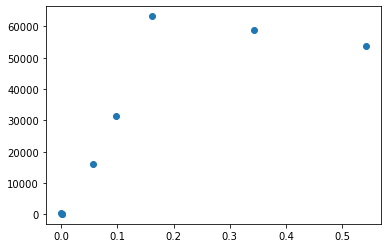

In [11]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False


# Import the value for each integrases in a list

cyto= [31370.285,
 16232.096,
 63220.477,
 373.34436,
 58798.445,
 162.51492,
 53784.26,
 149.13892]

#put in a dataframe both value for easier ploting 

cf = ints[-1:].T 

df_correl = pd.DataFrame(cf)
df_correl['Cyto']=cyto
df_correl = df_correl.rename(columns={96:"Cell-free"})
print(df_correl)

plt.scatter('Cell-free','Cyto',data=df_correl)
plt.show()

In [40]:
df_correl.corr()

,Cell-free,Cyto
Cell-free,1.000000,0.787611
Cyto,0.787611,1.000000


In [38]:
print('The pearson correlation coefficient is '+ str(round(pearsonr(df_correl['Cell-free'],df_correl['Cyto'])[0],2))
      + ' with p_value= '+str(round(pearsonr(df_correl['Cell-free'],df_correl['Cyto'])[1],2)))

print('The spearman correlation coefficient is '+ str(round(spearmanr(df_correl['Cell-free'],df_correl['Cyto'])[0],2))
      + ' with p_value= '+str(round(spearmanr(df_correl['Cell-free'],df_correl['Cyto'])[1],2)))


The pearson correlation coefficient is 0.79 with p_value= 0.02
The spearman correlation coefficient is 0.81 with p_value= 0.01


The values look correlated, lets try to fit a linear regression

# Linear regression

Trying to predict Y by X in our case predict cytometer data from cell free data 

Slope: 110781.425463
Intercept: 11345.959
Mean squared error: 252362730.229
Coefficient of determination: 0.620
F value: 9.8
P-value: 2.03e-02


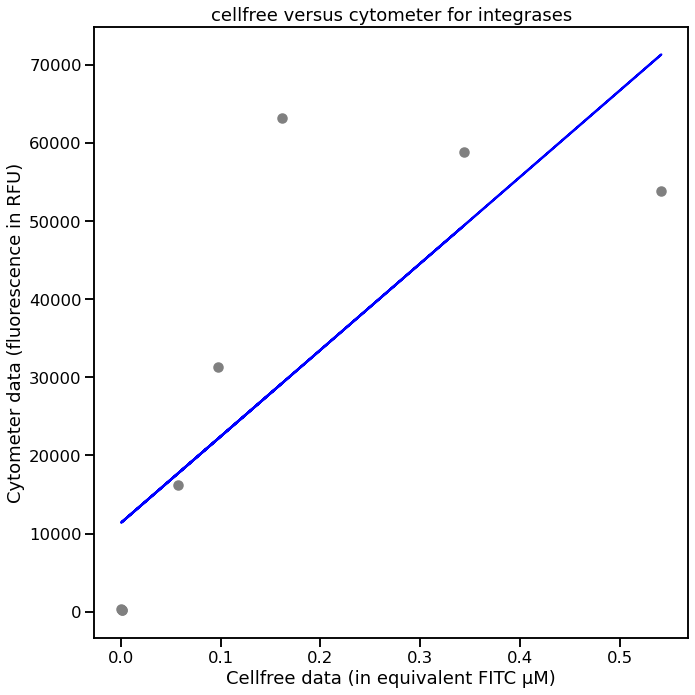

In [113]:
y = df_correl['Cyto'].to_numpy().reshape(-1,1) # sklearn wants 2D arrays in case of several independent variables
X = df_correl['Cell-free'].to_numpy().reshape(-1,1)
reg = linear_model.LinearRegression()
reg.fit(X, y)

print('Slope: %.6f' % reg.coef_)
print('Intercept: %.3f' % reg.intercept_)
pred_y = reg.predict(X)

print("Mean squared error: %.3f" % metrics.mean_squared_error(y, pred_y))
print("Coefficient of determination: %.3f" % metrics.r2_score(y, pred_y))

# significance
f_stat = feature_selection.f_regression(X, y[:,0])
print('F value: %.1f' % f_stat[0])
print('P-value: %.2e' % f_stat[1])

# visualization
fig,ax = plt.subplots()
fig.set_size_inches(10,10)

sns.set_context("talk")
plt.scatter(X, y, color = 'gray')
plt.plot(X, pred_y, color = 'blue')
plt.title('cellfree versus cytometer for integrases')
plt.ylabel('Cytometer data (fluorescence in RFU)')
plt.xlabel('Cellfree data (in equivalent FITC µM)')
plt.tight_layout()
plt.savefig('plots/linear_regression_integrase.png',dpi=300)
plt.show()

# Robust linear regression (to account for outliers)

## Huber regression

Slope: 12034.769443
Intercept: 0.000
Mean squared error: 170086238396628288.000
Coefficient of determination: -5062447340242391040.000
F value: 9.8
P-value: 2.03e-02


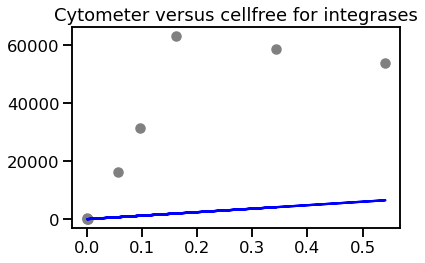

In [78]:
X = df_correl['Cyto'].to_numpy().reshape(-1,1) # sklearn wants 2D arrays in case of several independent variables
y = df_correl['Cell-free'].to_numpy().reshape(-1,1)
reg = HuberRegressor(epsilon=1,fit_intercept=False,max_iter=1000)
reg.fit(y, X)

print('Slope: %.6f' % reg.coef_)
print('Intercept: %.3f' % reg.intercept_)
pred_X = reg.predict(y)

print("Mean squared error: %.3f" % metrics.mean_squared_error(y, pred_y))
print("Coefficient of determination: %.3f" % metrics.r2_score(y, pred_y))

# significance
f_stat = feature_selection.f_regression(X, y[:,0])
print('F value: %.1f' % f_stat[0])
print('P-value: %.2e' % f_stat[1])

# visualization
fig,ax = plt.subplots()
#fig.set_size_inches(10,10)

sns.set_context("talk")
plt.scatter(y, X, color = 'gray')
plt.plot(y, pred_X, color = 'blue')
plt.title('Cytometer versus cellfree for integrases')
#plt.xlabel('Cytometer data (fluorescence in RFU)')
#plt.ylabel('Cellfree data (in equivalent FITC µM)')
plt.tight_layout()
#plt.savefig('plots/linear_regression_integrase.png',dpi=300)
plt.show()

Doesn't work that well probably due to the low number of data points 

## Quantile regression: less sensitive than mean

In [114]:
df_c = df_correl.rename(columns={'Cell-free':'cellfree'})
#print(df_c.head())

model = smf.quantreg('Cyto ~ cellfree', df_c).fit(q=0.5)

#view model summary
print(model.summary())

                         QuantReg Regression Results                          
Dep. Variable:                   Cyto   Pseudo R-squared:               0.4975
Model:                       QuantReg   Bandwidth:                   2.819e+04
Method:                 Least Squares   Sparsity:                    5.289e+04
Date:                Sun, 20 Mar 2022   No. Observations:                    8
Time:                        16:18:40   Df Residuals:                        6
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    294.1449   1.21e+04      0.024      0.981   -2.93e+04    2.99e+04
cellfree    1.703e+05    5.1e+04      3.338      0.016    4.54e+04    2.95e+05


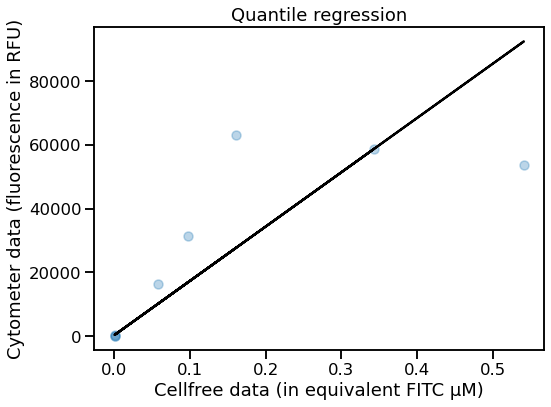

In [116]:
fig, ax = plt.subplots(figsize=(8, 6))

cellfree= df_c['cellfree']
cyto = df_c['Cyto']

#get y values
get_y = lambda a, b: a + b * cellfree
y = get_y(model.params['Intercept'], model.params['cellfree'])

#plot data points with quantile regression equation overlaid
ax.plot(cellfree, y, color='black')
ax.scatter(cellfree, cyto, alpha=.3)
plt.title('Quantile regression')
ax.set_ylabel('Cytometer data (fluorescence in RFU)')
ax.set_xlabel('Cellfree data (in equivalent FITC µM)')
plt.tight_layout()
plt.savefig('plots/quantile_regression_integrase.png',dpi=300)

plt.show()

# Tests

In [165]:
def f(x, r):
    """Discrete logistic equation with parameter r"""
    return r*x*(1-x)

def logifunc(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off

y = df_correl['Cyto'].tolist() # sklearn wants 2D arrays in case of several independent variables
X = sorted(df_correl['Cell-free'].tolist())

print(y)
def error2(param,data):
    X = data[0]
    y = data[1]
    r = param[0]
    error = []
    z =[]
    for i in range(len(X)):
        z.append(f(X[i],r))
    for i in range(len(z)):
        error.append((z[i]-y[i])**2)
        
    errors = np.sum(error)
    return errors

param =[10000]
s2 = minimize(error2,param,args = (data),method='Powell')
#print(s2.x)
#print(error2(s2.x,data))


def error(param,data):
    X = data[0]
    y = data[1]
    A = param[0]
    x0 = param[1]
    k = param[2]
    off = param[3]
    error = []
    z =[]
    for i in range(len(X)):
        z.append(logifunc(X[i],A,x0,k,off))
    for i in range(len(z)):
        error.append((z[i]-y[i])**2)
        
    errors = np.sum(error)
    return errors

#print(error([64220.476933747086, 39999.99936916684, 9999.99996262314, 28011.32021666667],[X,y]))
parami = [64220.476933747086, 39999.99936916684, 9999.99996262314, 28011.32021666667]
data = [X,y]
s = minimize(error,parami,args = (data),method='Powell',bounds=([(0,max(y)+1000),(0,40000),(0,100000),(min(y),max(y))]))


[31370.285, 16232.096, 63220.477, 373.34436, 58798.445, 162.51492, 53784.26, 149.13892]
